In [1]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score  # or accuracy_score for classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy.stats import pearsonr
import gc

In [2]:
train_df = pd.read_parquet("../data/train_clean_v2.parquet")
test_df = pd.read_parquet("../data/test_clean_v2.parquet")
feat_importance_df = pd.read_csv("../data/lgbm_feature_importance.csv")

In [ ]:
target_col = "label"
feature_cols = [col for col in train_df.columns if col != target_col]

X = train_df[feature_cols]
y = train_df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=None)

top_n_list = [40, 100, 200, 300, 400]
results = []
all_logs = {}

In [4]:
def pearson_corr_metric(preds, data):
    y_true = data.get_label()
    return 'pearson', np.corrcoef(y_true, preds)[0, 1], True

In [5]:
best_model = None
best_score = -np.inf
best_n = None

for top_n in top_n_list:
    top_features = feat_importance_df.sort_values("importance", ascending=False).head(top_n)["feature"].tolist()

    dtrain = lgb.Dataset(X_train[top_features], label=y_train)
    dval = lgb.Dataset(X_val[top_features], label=y_val)

    train_losses = []
    val_losses = []

    def record_log(env):
        train_score = env.evaluation_result_list[0][2]
        val_score = env.evaluation_result_list[1][2]
        train_losses.append(train_score)
        val_losses.append(val_score)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "verbosity": 1,
    }

    model = lgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        feval=pearson_corr_metric,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0),
            record_log
        ],
        keep_training_booster=False
    )

    y_pred = model.predict(X_val[top_features], num_iteration=model.best_iteration)
    pearson_corr = pearsonr(y_val, y_pred)[0]
    results.append((top_n, pearson_corr))
    print(f"Top {top_n} features: Pearson = {pearson_corr:.5f}")

    all_logs[top_n] = (train_losses, val_losses)

    if pearson_corr > best_score:
        best_score = pearson_corr
        best_model = model
        best_n = top_n

    del model, dtrain, dval
    gc.collect()


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10192
[LightGBM] [Info] Number of data points in the train set: 473298, number of used features: 40
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 40 dense feature groups (18.05 MB) transferred to GPU in 0.008278 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.037007
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.299359	train's pearson: 0.958935	val's rmse: 0.32982	val's pearson: 0.950963
Top 40 features: Pearson = 0.95096
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25492
[LightGBM] [Info] Number of da

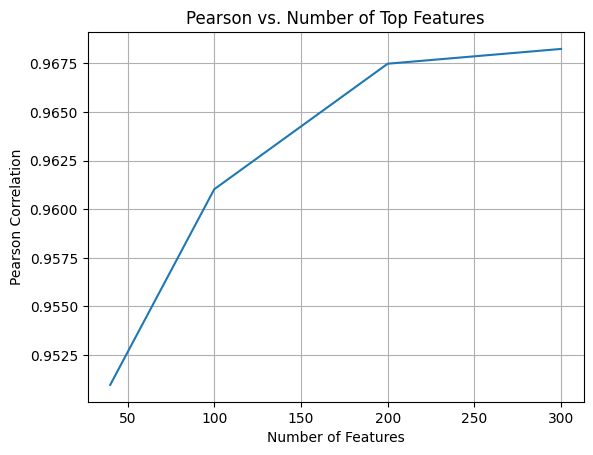

In [6]:
import matplotlib.pyplot as plt
n_features, pearsons = zip(*results)
plt.figure()
plt.plot(n_features, pearsons)
plt.xlabel("Number of Features")
plt.ylabel("Pearson Correlation")
plt.title("Pearson vs. Number of Top Features")
plt.grid(True)
# plt.savefig("../data/pearson_vs_n_features.png")
plt.show()

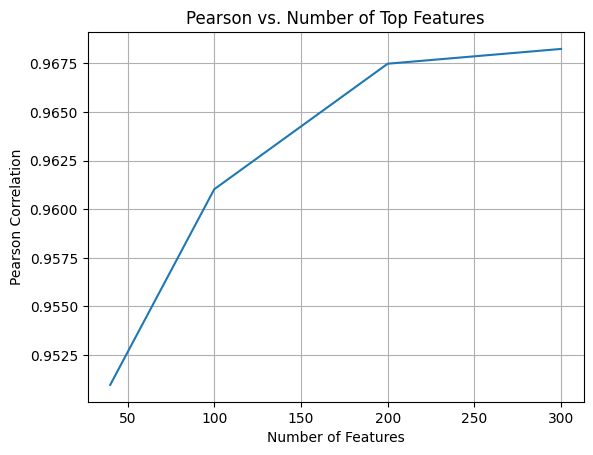

In [7]:
n_features, pearsons = zip(*results)
plt.figure()
plt.plot(n_features, pearsons)
plt.xlabel("Number of Features")
plt.ylabel("Pearson Correlation")
plt.title("Pearson vs. Number of Top Features")
plt.grid(True)
# plt.savefig("../data/pearson_vs_n_features.png")
plt.show()

In [8]:
best_model.save_model(f"../data/lightgbm_top{best_n}_features.txt")

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb

def generate_submission(top_n_features: int, model_dir="../data", feature_importance_path="lgbm_feature_importance.csv", test_path="../data/test_clean_v2.parquet"):
    
    model_path = f"{model_dir}/lightgbm_top{top_n_features}_features.txt"
    model = lgb.Booster(model_file=model_path)

    top_features = feat_importance_df.sort_values("importance", ascending=False).head(top_n_features)["feature"].tolist()
    
    preds = model.predict(test_df[top_features], num_iteration=model.best_iteration)

    submission = pd.DataFrame({
        "ID": np.arange(1, len(test_df) + 1),  # 1-indexed IDs oops mine were 0-indexed
        "prediction": preds
    })

    sub_path = f"{model_dir}/lightgbm_top{top_n_features}_submission.csv"
    submission.to_csv(sub_path, index=False)
    print(f"Saved submission to {sub_path}")

    return submission

In [ ]:
generate_submission(400)

Saved submission to ../data/lightgbm_top300_submission.csv


,ID,prediction
0,1,0.320511
1,2,-0.018170
2,3,0.721232
3,4,-0.340231
4,5,1.130049
...,...,...
538145,538146,0.907301
538146,538147,0.089801
538147,538148,0.496133
538148,538149,-0.095576


In [ ]:
# test